In [1]:
include("F:/Tue/Master/Thesis/codes/GP_CVI/BayesianUtilities-main/BayesianUtilities-main/BayesianUtilities.jl")
using Distributions, LinearAlgebra, Plots, Random, .BayesianUtilities, Zygote
using DataStructures: Queue, enqueue!, dequeue!
using Flux.Optimise
using CSV, DataFrames, JLD

In [2]:
include("F:/Tue/PhD/Eusipco_paper/predict_ICM.jl");
include("F:/Tue/PhD/Eusipco_paper/optimize_ICM.jl");

In [3]:
data = CSV.read("F:\\Tue\\Master\\Thesis\\codes\\GP_CVI\\Covid_RIVM.csv",DataFrame, delim=";");
observation = Float64.(data.Tested_positive)
T = length(observation);

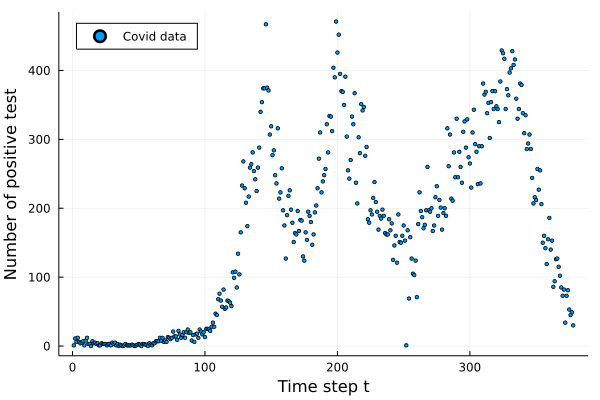

In [4]:
scatter(observation, label = "Covid data", legend = :topleft, markersize=2)
ylabel!("Number of positive test")
xlabel!("Time step t")

In [5]:
# Newtonian dynamics assumption
A = [1. 1.; 0. 1.]
B = [1. 0.]

# Priors
p_z_init = MvNormal(zeros(2),diagm(0=>ones(2)))
#p_W = Wishart(2,diagm(0=>ones(2)))
W = diagm(0=>ones(2))

# Non-conjugate loglikelihood function
function log_likelihood(y,z)
    x = exp((B*z)[1]) # B*z returns 1 dimensional array
    logpdf(Poisson(x),y)
end

log_likelihood (generic function with 1 method)

In [6]:
function approx_message_z(obs::Real,mes_income::MvNormal,η::Real,n_its::Int)
    opt = AdaMax(η) #change at this location: different optimizer
    q = mes_income # initialize variational distribution with closed form incoming message
    _, _, λ_q, _, _ = exp_family(q) # initial variational parameters
    λ_m = zeros(6) # initial message parameters
    violation = 0 # keep track of number of updates lead to invalid parameters 
    for n=1:n_its
        logp(z) = log_likelihood(obs,z)
        grad = cvi(logp,q) # grad estimates
        λ_m_old = copy(λ_m); #check convergence
        update!(opt,λ_m,λ_m - grad)
        λ_q = λ_q .+ λ_m # update variational parameters
        try
            q = exp_family(MvNormal, λ_q) # update q
            if norm(λ_m - λ_m_old) < 1e-4
                    #println("Converged in step ",n)
                    break
                end
        catch
            λ_q = λ_q .- λ_m # avoid updates that violate the support of Gaussian
            violation += 1
            @show violation
        end
    end
    return λ_m # return approximate message parameters
end

approx_message_z (generic function with 1 method)

In [7]:
#Parameters for ICM
 
σ, l = 2, [0.1, 0.2, 0.18, 0.26, 0.14, 0.09, 5.];

eye_matrix =1* Matrix(I, 6,6); #identity matrix
C= eye_matrix; #Coregionalization matrix

In [113]:
function filter_GP(W, T)
    time = []; #store time
    count_new = 0; #count the number of new added observations = number of samples needs cvi
    GP_train_size = []; #store the size of training set after updating
    uncertainty = []; #store uncertainty
    uptime = [];
    forward_estimates = Array{MvNormal}(undef, T)
    λ_m = approx_message_z(observation[1],p_z_init,0.4,15000);   
    _, _, λ_p, _, _ = exp_family(p_z_init);
    gp_input = vcat(λ_p, observation[1]); #this is our input
    gp_output = λ_m; #this is our output
    forward_estimates[1] = collide(p_z_init,Canonical(MvNormal, λ_m));
    ### Collect the first 25 samples for GP
    for t=2:25
        predict = A*forward_estimates[t-1] + MvNormal(zeros(2),Matrix(Hermitian(inv(W))));
        #start collecting data for Gp
         _, _, λ_pre, _, _ = exp_family(predict);
        temp = vcat(λ_pre,observation[t]); # use this variable to store new input
        gp_input = hcat(gp_input, temp); # collect new input data for GP
        
        λ_m = approx_message_z(observation[t],predict,0.4,15000);
        gp_output = hcat(gp_output,λ_m); # collect output for GP
        forward_estimates[t] = collide(predict,Canonical(MvNormal, λ_m));
    end
    ### Train GP
    σ_op, l_op = optim_gp_adamax(gp_input,gp_output, C, σ, l, 1e-4,5,1000); #optimal parameters of the first output element
    ### Use GP to predict the rest
    for t=26:T
        t1 = @elapsed predict = A*forward_estimates[t-1] + MvNormal(zeros(2),Matrix(Hermitian(inv(W))));
        t2 = @elapsed _, _, λ_pre, _, _ = exp_family(predict);
        t3 = @elapsed temp = vcat(λ_pre,observation[t]); # new point

        t4 = @elapsed λ_m, var_predict = icm_predict(gp_input,gp_output,temp,C, σ_op,l_op); #Predict
        t5 = @elapsed var_ele = diag(var_predict); # this vector stores the predictive variance of each output component
        
        if t==26
            uncertainty = append!(uncertainty,var_ele)
        else
            uncertainty = hcat(uncertainty, var_ele)
        end
        t6 = 0
        #check uncertainty, if greater than pre-defined threshold, then collect new data
        if var_ele[1] >= .8
            t7 = @elapsed λ_m = approx_message_z(observation[t],predict,0.4,15000); #use CVI
            gp_input = hcat(gp_input,temp); #observe new input
            gp_output = hcat(gp_output,λ_m); #observe new output
            count_new += 1;
            if count_new == 50 #Nnew here
                #optimal parameters of the first output element
                t6 = @elapsed σ_op, l_op = optim_gp_adamax(gp_input,gp_output, C, σ_op, l_op, 1e-4,5,100)
                count_new = 0;
                uptime = append!(uptime,t)
            end
        else
            t7 = 0;
        end
        GP_train_size = append!(GP_train_size,size(gp_input,2))
        t8 = @elapsed forward_estimates[t] = collide(predict,Canonical(MvNormal, λ_m));
        time = append!(time, t1 + t2 + t3 + t4 + t5 + t6 + t7 +t8); #start from t=26
    end
    
    return forward_estimates, GP_train_size, time, uncertainty, uptime
end


filter_GP (generic function with 1 method)

In [114]:
function filter_CVI(W, T)
    time = [];
    forward_estimates = Array{MvNormal}(undef, T);
    λ_m = approx_message_z(observation[1],p_z_init,0.4,15000);   
    forward_estimates[1] = collide(p_z_init,Canonical(MvNormal, λ_m));
    for t=2:T
       t1 = @elapsed predict = A*forward_estimates[t-1] + MvNormal(zeros(2),Matrix(Hermitian(inv(W))));
       t2 = @elapsed λ_m = approx_message_z(observation[t],predict,0.4,15000);
       t3 = @elapsed forward_estimates[t] = collide(predict,Canonical(MvNormal, λ_m));
        time = append!(time,t1+t2+t3); #start from t=2
    end
    return forward_estimates, time
end


function smooth(forward_estimates,W, T)
    smooth_estimates = Array{MvNormal}(undef, T);
    smooth_estimates[T] = forward_estimates[T];
    joint_dists = Array{MvNormal}(undef, T-1);
    for t=T-1:-1:1
        smooth_estimates[t], joint_dists[t] = transit(forward_estimates[t],smooth_estimates[t+1],A,W);
    end
    return smooth_estimates, joint_dists
end


smooth (generic function with 1 method)

## CVI

In [115]:
Random.seed!(150)
@time begin
forward_estimates_cvi, time_cvi = filter_CVI(W,T);
smooth_estimates_CVI, joint_dists_CVI = smooth(forward_estimates_cvi, W, T);
end
;

 76.381070 seconds (314.09 M allocations: 28.809 GiB, 8.81% gc time)


## GP

In [116]:
Random.seed!(150)
@time begin
forward_estimates_gp, training_size, time_gp, uncertainty, uptime = filter_GP(W,T);
smooth_estimates_GP, joint_dists_GP = smooth(forward_estimates_gp, W, T);
end
;

 62.315519 seconds (131.56 M allocations: 18.989 GiB, 6.02% gc time)


In [102]:
uptime

2-element Array{Any,1}:
 149
 277

## Plot result

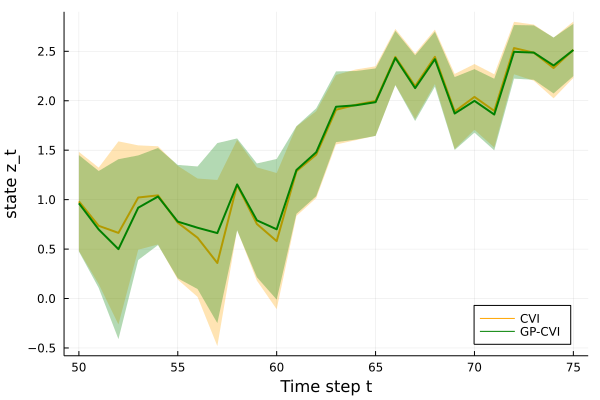

In [69]:
state1_est_GP = zeros(T)
state1_est_CVI = zeros(T)

var1_est_GP = zeros(T)
var1_est_CVI = zeros(T)

for t=1:T
    state1_est_GP[t] = mean(smooth_estimates_GP[t])[1]
    state1_est_CVI[t] = mean(smooth_estimates_CVI[t])[1]
    
    var1_est_GP[t] = var(smooth_estimates_GP[t])[1]
    var1_est_CVI[t] = var(smooth_estimates_CVI[t])[1]
end

plot(50:75, state1_est_CVI[50:75],label = "CVI", lw = 2, color = :orange, ribbon = sqrt.(var1_est_CVI[50:75]), fillalpha=0.3)
plot!(50:75, state1_est_GP[50:75],label = "GP-CVI", legend = :bottomright, 
    ylabel = "state z_t", xlabel = "Time step t", lw = 2, color = :green, ribbon = sqrt.(var1_est_GP[50:75]), fillalpha=0.3)

In [26]:
savefig("F:\\Tue\\Master\\Thesis\\Presentation and report\\result.png")

In [70]:
gp_pos = findall(x->x<0.8, uncertainty[1,:]) .+ 25 ; #positions at which the result is generated by GP

In [71]:
#cvi_pos = collect(1:25)
cvi_pos = findall(x->x>=0.8, uncertainty[1,:]) .+ 25;
#append!(cvi_pos,cvi_pos_add);

In [72]:
uncer = uncertainty[1,:];


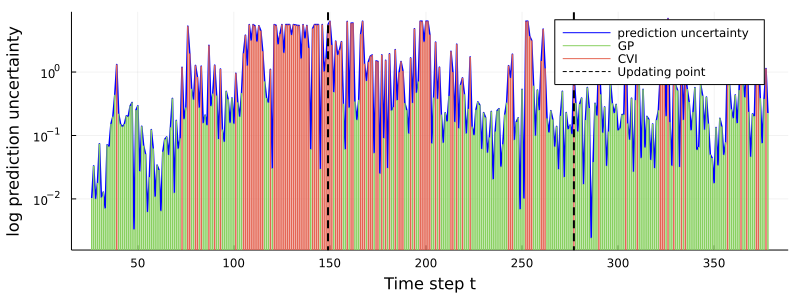

In [73]:
## different plots
plot(26:T,uncer, label = "prediction uncertainty", ylabel = "log prediction uncertainty", xlabel = "Time step t", lw=1.6,color = :blue, size = (800, 300),
    left_margin = 4Plots.mm, bottom_margin =5Plots.mm, legend = :topright, g_inside = cgrad(:grayC)[80], yaxis= (:log10,[0.002, :auto]))
plot!(gp_pos,uncer[gp_pos.-25], seriestypes= :sticks, lw =1.5,label = "GP", color = cgrad(:haline)[200])
plot!(cvi_pos,uncer[cvi_pos.-25], seriestypes= :sticks,lw=1.5,label = "CVI", color = cgrad(:matter)[100])
plot!([uptime[1],uptime[2]],seriestype="vline", color = :black, lw = 2, ls = :dash,label = "Updating point")

In [57]:
savefig("F:\\Tue\\Master\\Thesis\\Presentation and report\\uncertainty.png")

## Calculate FE

In [117]:
Random.seed!(150)
FE_cvi = []; #store FE values at each time step
for t=1:T
    if t==1
        FE_temp = -entropy(smooth_estimates_CVI[1]) + cross_entropy(smooth_estimates_CVI[1], p_z_init);
        FE_temp -= normal_conditional_entropy(smooth_estimates_CVI[t], smooth_estimates_CVI[t+1], joint_dists_CVI[t]);
        Av_t = 0;
        for s=1:500
            Av_t -= log_likelihood(observation[t],rand(smooth_estimates_CVI[t]));
        end
        FE_temp += Av_t/500;
        append!(FE_cvi,FE_temp);
    elseif t==T
        Av_t = 0;
        for s=1:500
            Av_t -= log_likelihood(observation[t],rand(smooth_estimates_CVI[t]));
        end
        FE_temp = Av_t/500;
        append!(FE_cvi,FE_temp);
    else
        FE_temp = -normal_conditional_entropy(smooth_estimates_CVI[t], smooth_estimates_CVI[t+1], joint_dists_CVI[t]);
        Av_t = 0;
        for s=1:500
            Av_t -= log_likelihood(observation[t],rand(smooth_estimates_CVI[t]));
        end
        FE_temp += Av_t/500;
        append!(FE_cvi,FE_temp);
    end
end
sum(FE_cvi)

1295.9699335675118

In [118]:
Random.seed!(150)
FE_gp = []; #store FE values at each time step
for t=1:T
    if t==1
        FE_temp = -entropy(smooth_estimates_GP[1]) + cross_entropy(smooth_estimates_GP[1], p_z_init);
        FE_temp -= normal_conditional_entropy(smooth_estimates_GP[t], smooth_estimates_GP[t+1], joint_dists_GP[t]);
        Av_t = 0;
        for s=1:500
            Av_t -= log_likelihood(observation[t],rand(smooth_estimates_GP[t]));
        end
        FE_temp += Av_t/500;
        append!(FE_gp,FE_temp);
    elseif t==T
        Av_t = 0;
        for s=1:500
            Av_t -= log_likelihood(observation[t],rand(smooth_estimates_GP[t]));
        end
        FE_temp = Av_t/500;
        append!(FE_gp,FE_temp);
    else
        FE_temp = -normal_conditional_entropy(smooth_estimates_GP[t], smooth_estimates_GP[t+1], joint_dists_GP[t]);
        Av_t = 0;
        for s=1:500
            Av_t -= log_likelihood(observation[t],rand(smooth_estimates_GP[t]));
        end
        FE_temp += Av_t/500;
        append!(FE_gp,FE_temp);
    end
end
sum(FE_gp)

1296.4341345621126

## Calculate inference time

In [119]:
#Calculate time for each interval
interval = append!([26],uptime);
time1 = sum(time_gp[1:uptime[1]-25]); #from 26 to uptime1
time2 = sum(time_gp[uptime[1]-24:uptime[2]-25]); #from uptime1 +1 to uptime 2
time3 = sum(time_gp[uptime[2]-24:end]); #from uptime 2 to end

In [120]:
[time1, time2, time3]

3-element Array{Float64,1}:
 14.871020001999998
 24.144258211999993
 13.423119614000006

In [121]:
timecvi_1 = sum(time_cvi[25:uptime[1]-1]);
timecvi_2 = sum(time_cvi[uptime[1]:uptime[2]-1]);
timecvi_3 = sum(time_cvi[uptime[2]:end]);

In [122]:
[timecvi_1, timecvi_2, timecvi_3]

3-element Array{Float64,1}:
 17.274095390999996
 30.936664895000003
 24.911502198999994

### Other stuffs

In [88]:
function moving_avg(x::Array, window_size::Int)
    out = Vector{Float64}(undef,length(x)-window_size+1);
    for i=1:length(out)
        out[i] = sum(x[i:i+window_size-1])/window_size;
    end
    return out
end

moving_avg (generic function with 1 method)

In [89]:
mov_var = moving_avg(uncertainty[1,:],9);

## Plot uncertainty

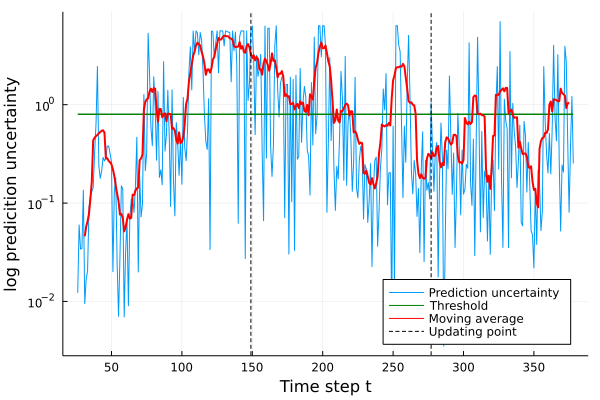

In [23]:
#plot uncertainty of 1st component
plot(26:T,uncertainty[1,:], label = "Prediction uncertainty", lw = 1, yaxis = :log10, legend = :bottomright, legendfontsize=8)


plot!(26:T,0.8 .*ones(length(26:T)),lw = 1.5, color =:green,label = "Threshold")
plot!(31:31+length(mov_var)-1, mov_var, lw=2, color = :red, label="Moving average")
plot!([uptime[1],uptime[2]],seriestype="vline", color = :black, lw = 1, ls = :dash,label = "Updating point")
ylabel!("log predicition uncertainty")
xlabel!("Time step t")

In [45]:
savefig("F:\\Tue\\Master\\Thesis\\Presentation and report\\uncertainty.png")

In [90]:
mov_avg_time_gp = Vector{Vector{Float64}}(undef,length(uptime)+1);
mov_avg_time_cvi = Vector{Vector{Float64}}(undef,length(uptime)+1);
for i=1:length(uptime)+1
    if i==1
        mov_avg_time_gp[i] = moving_avg(time_gp[1:uptime[i]-26],19)
        mov_avg_time_cvi[i] = moving_avg(time_cvi[25:uptime[i]-2],19)
    elseif i==length(uptime)+1
        mov_avg_time_gp[i] = moving_avg(time_gp[uptime[i-1]-24:end],19)
        mov_avg_time_cvi[i] = moving_avg(time_cvi[uptime[i-1]:end],19)
    else
        mov_avg_time_gp[i] = moving_avg(time_gp[uptime[i-1]-24:uptime[i]-26],19)
        mov_avg_time_cvi[i] = moving_avg(time_cvi[uptime[i-1]:uptime[i]-2],19)
    end
end


In [91]:
mov_avgtimegp = vcat(mov_avg_time_gp...);
mov_avgtimecvi = vcat(mov_avg_time_cvi...);

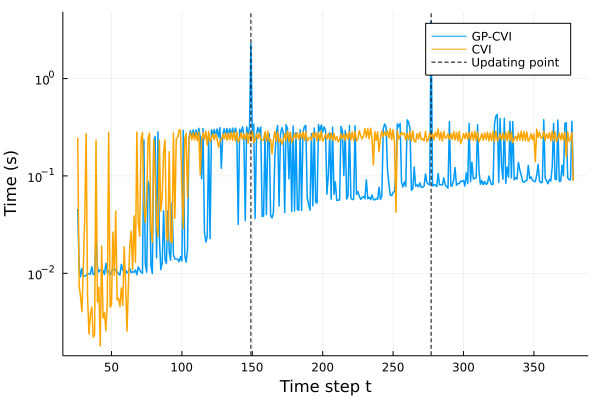

In [92]:
#Plot time
plot(26:T,time_gp, yaxis = :log10, label="GP-CVI", linewidth = 1.5, legendfontsize=8)
plot!(26:T,time_cvi[25:end], label="CVI", color = :orange, linewidth = 1.5)
plot!([uptime[1],uptime[2]],seriestype="vline", color = :black, lw = 1, ls = :dash,label="Updating point")

xlabel!("Time step t")
ylabel!("Time (s)")

In [47]:
savefig("F:\\Tue\\Master\\Thesis\\Presentation and report\\Time comparision.png")

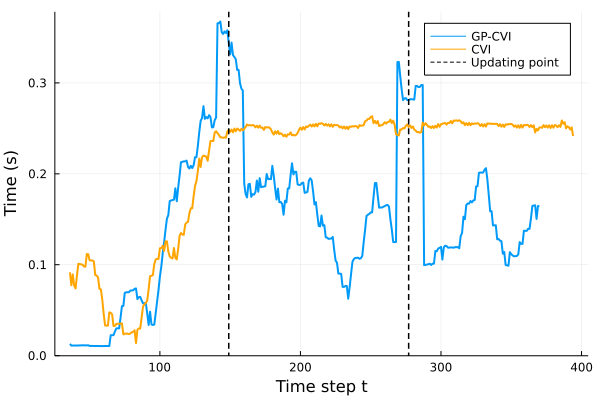

In [93]:
plot(36:36+length(moving_avg(time_gp,19))-1,moving_avg(time_gp,19), linewidth = 2, label = "GP-CVI", 
    legendfontsize = 8, legend = :best)
plot!(36:36+length(moving_avg(time_cvi,19))-1,moving_avg(time_cvi,19), color = :orange, linewidth = 2, label = "CVI")
plot!([uptime[1],uptime[2]],seriestype="vline", color = :black, lw = 1.5, ls = :dash,label="Updating point")
xlabel!("Time step t")
ylabel!("Time (s)")

In [49]:
savefig("F:\\Tue\\Master\\Thesis\\Presentation and report\\time movave comparision.png")

In [94]:
sum(time_gp[uptime[2]+1-25:end])

13.808124905000009

In [95]:
sum(time_cvi[uptime[2]:end])

25.443998803000017